In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import glob 
from common.trajectory_analysis import Trajectory
from common.util import DelayLine
import scipy

In [2]:
def interpolate(ts, xs, new_ts):
    x_spline = scipy.interpolate.UnivariateSpline(ts, xs, k=3, s=0)
    new_xs = x_spline(new_ts)
    return new_xs

In [3]:
def distance(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

In [4]:
pxtomm = 160/1080 #[mm/px] for Huion H610p
center = centerx, centery = 800 * pxtomm, 450 * pxtomm


In [5]:
class Data:
    def __init__(self, filename, dt=0.005, cut = None, smooth_t=None, smooth_c=None):
        d = json.load(open(filename))
        self.filename = filename
        self.tts = np.array(d["tts"])  # time
        self.txs = np.array(d["txs"]) * pxtomm  # target x
        self.tys = np.array(d["tys"]) * pxtomm  # tatget y
        self.cxs = np.array(d["cxs"]) * pxtomm  # cursor (pen) x
        self.cys = np.array(d["cys"]) * pxtomm  # cursor (pen) y
        self.ss  = np.array(d["ss"]) * pxtomm   # sizes
        self.fs  = np.array(d["fs"])  # frequencies

        self.tr  = Trajectory(self.txs, self.tys, self.tts, dt = dt, cut=cut, smooth = smooth_t)
        self.cr  = Trajectory(self.cxs, self.cys, self.tts, dt = dt, cut=cut, smooth = smooth_c)        
        self.sst = interpolate(self.tts, self.ss, self.tr.t)
        self.a   = self.sst[:]
        self.b   = self.sst[:] / 2
        self.fst = interpolate(self.tts, self.fs, self.tr.t)        

        centerx, centery = center = 800*pxtomm, 450*pxtomm
        self.tph = np.unwrap(np.arctan2(self.tr.y - centery, self.tr.x - centerx))
        self.cph = np.unwrap(np.arctan2(self.cr.y - centery, self.cr.x - centerx))
        self.dph = self.cph - self.tph
        
        r =  np.array([distance((self.cr.x[i], self.cr.y[i]), center) for i in range(len(self.cr.t))])
        r_ratio = 2
        self.rc =  r *  np.sqrt(np.cos(self.cph)**2 + (r_ratio*np.sin(self.cph))**2)
        self.ds = self.a - self.rc
        


In [6]:
dt = 0.005

files = glob.glob("..//data3//*phase and size track*.json")
data = [Data(f, smooth_c = 10, cut=[6, 1], dt=dt) for f in files]

In [7]:
class Oscillator:
    def __init__(s, dt, A=1, B=1, cx=0, cy=0, init_phase=0):
        s.x = np.cos(init_phase)
        s.y = np.sin(init_phase)
        s.dt = dt
        s.cx = cx
        s.cy = cy
        s.out = np.array([s.cx + A * s.x, s.cy + B * s.y])
            
    def step(s, f, A=1, B=1):
        s.y +=  -s.x *  f * s.dt * 2 * np.pi
        s.x +=   s.y *  f * s.dt * 2 * np.pi
        s.out = np.array([s.cx + A * s.x, s.cy + B * s.y])


class FirstOrderModel:
    """First order model with delay
       error signal delayed (after reference)
    """
    def __init__(self, K, B, tau, dt, init_err=0, init_out=0):
        self.K = K
        self.B = B
        self.tauN = int(tau / dt)
        self.delayed_err = DelayLine(self.tauN, init_err)
        self.dt = dt
        self.out = init_out

    def step(self, new_p, new_r):
        new_err = new_r - new_p
        e = self.delayed_err(new_err)
        self.out = self.out + (self.K * e - self.B*self.out) * dt                

class Store:
    "helper class for storing simulation results"
    def __init__(self, N, *names):
        self.names = names
        for n in names:
            setattr(self, n, np.zeros(N))
        self.count = 0
            
    def step(self, *d):
        for i in range(len(d)):
            n = self.names[i]
            var = getattr(self, n) 
            var[self.count] = d[i]
        self.count += 1;
            
def butterworth(x, cutoff, samples_per_s=200, filter_order=2):
    B, A = signal.butter(filter_order, cutoff / (samples_per_s / 2), 'low')
    return signal.filtfilt(B, A, x, method="gust")

def rmse(a, b):
    ds = (a - b)**2
    return np.sqrt(np.mean(ds))


In [8]:
colors = {
    "target": "#882255",
    "cursor": "#44AA99",
    "virtual":"#547dde",
    "model" : "#f6914b"
}
import matplotlib
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 16}
matplotlib.rc('font', **font)

In [23]:
radius_ratio = 2

for d in data[:]:
    print(d.filename)
    t = d.tr
    c = d.cr
    
    target0 = np.array([t.x[0], t.y[0]])
    radiusx = radiusy =  distance((centerx, centery), target0)
    tph = d.tph[0]
    
    osc = Oscillator(dt, radiusx, radiusy, centerx, centery, tph)
    m = FirstOrderModel(10, 0.018, 0.100, dt, init_out=target0, init_err=np.array([0, 0]))
    cph =  np.arctan2(m.out[1] - centery, m.out[0] - centerx); 
    prev_cph = cph
    
    rx, ry = radiusx, radiusy
    
    last_dph = cph - tph
    last_rdif = 0
    f = -0.5
    
    last_vdph = 0
    prev_ds = 0

    delayed_phase     = DelayLine(int(0.000 / dt), 0)
    delayed_ds        = DelayLine(int(0.150 / dt), 0)
    
    N = len(t.t)
    
    d.model = Store(N, "mx", "my", "ox", "oy", "tph", "cph", "dph", "vdph", "f", "ds", "rc")

    for i in range(N):

        tph = d.tph[i]

        cph0 = np.arctan2(m.out[1] - centery, m.out[0] - centerx)
        cph  = np.unwrap([prev_cph, cph0])[1]; prev_cph = cph

        dph = delayed_phase(cph - tph)    

        vdph = (dph - last_dph) / dt
        last_dph = dph
        
        f = f + (0.5*dph + 0.3 * vdph )* dt 
        
        r =  distance(m.out, center)
        rc =  r *  np.sqrt(np.cos(cph)**2 + (radius_ratio*np.sin(cph))**2)
        
        ds = delayed_ds(d.a[i] - rc)
        vds = (ds - prev_ds)/dt
        prev_ds = ds
        
        rx = rx + (40 * ds - 0.5* vds - rx) * (dt / 30.0)
        ry = rx / radius_ratio

        osc.step(f, rx, ry)
        noise = np.random.normal(size=m.out.size, loc=0, scale=0.05)
        m.out += noise
        m.step(m.out, osc.out)            

        # store variables
        d.model.step(*m.out, *osc.out, tph, cph, dph, vdph, f, ds, rc)


    tm = d.model.t = t.t[0] + np.arange(len(d.model.mx)) * dt

..//data3\phase and size track 3 Tue Jan 11 19-14-51 2022.json
..//data3\phase and size track 3 Tue Jan 11 19-13-20 2022.json
..//data3\phase and size track 2 Tue Jan 11 19-07-35 2022.json
..//data3\phase and size track 2 Tue Jan 11 19-06-10 2022.json
..//data3\phase and size track 2 Tue Jan 11 19-04-42 2022.json
..//data3\phase and size track 2 Tue Jan 11 19-03-17 2022.json
..//data3\phase and size track 2 Tue Jan 11 19-01-17 2022.json
..//data3\phase and size track 1 Tue Jan 11 18-59-15 2022.json


In [10]:
from scipy import stats

for d in data:
    dx = d.cr.x - d.tr.x
    dy = d.cr.y - d.tr.y
    rx = stats.linregress(dx, d.tr.x)
    ry = stats.linregress(dy, d.tr.y)
    print(rx.rvalue, ry.rvalue)
    
    

-0.07075014609968665 -0.1735026547243522
-0.15450541586399386 -0.2718373496437261
-0.09604562034526519 -0.16003094856247815
-0.1657893774809039 -0.10031131302748957
-0.1928143984524275 -0.2736533116888135
-0.15008818328525958 -0.24859019437553895
-0.12774500819030676 -0.08287698569655211
-0.2747971609854807 -0.24737389658922865


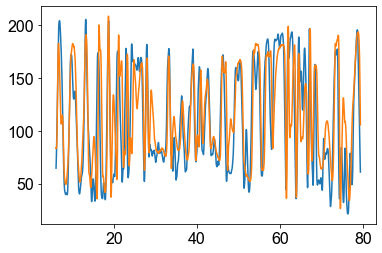

0.4384873361993855
0.19882495258507077


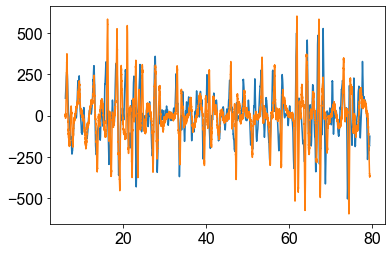

-0.21766066219036162
0.14917999589804493


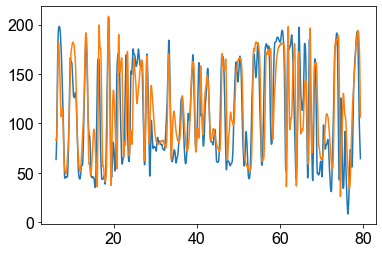

0.4731580624681553
0.17454111468741346


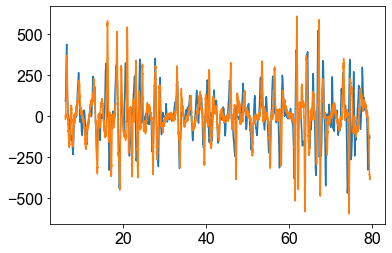

-0.20771891476076187
0.1529663622971719


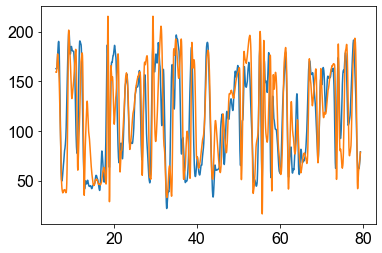

0.3840283897521666
0.20190597248606262


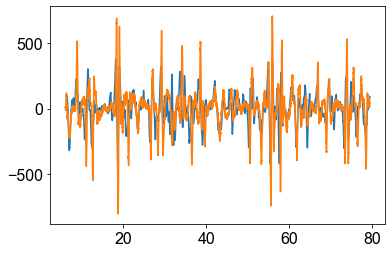

-0.66149567442452
0.18518432638845392


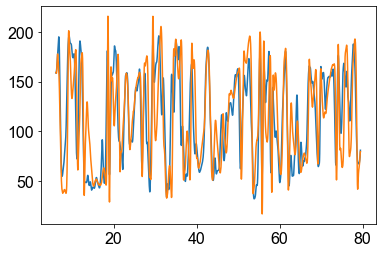

0.41427769526847114
0.20927882690068372


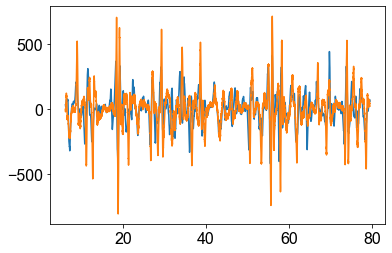

-0.5910145516705838
0.1753842907928301


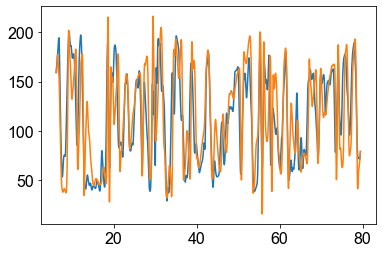

0.46088593605446215
0.1928179112353321


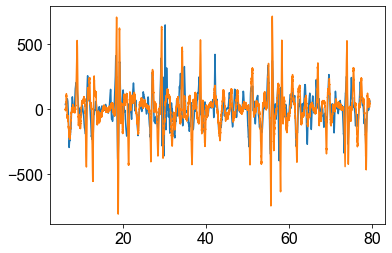

-0.5652158337216997
0.14463704989487647


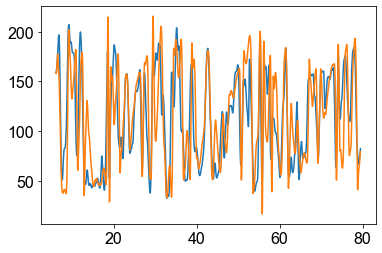

0.4149817400663116
0.19808441550034375


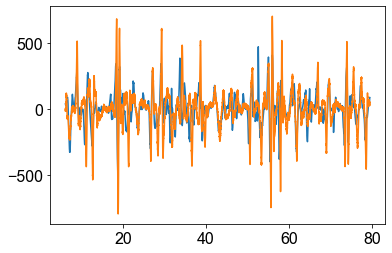

-0.5483752946610858
0.15594593467296197


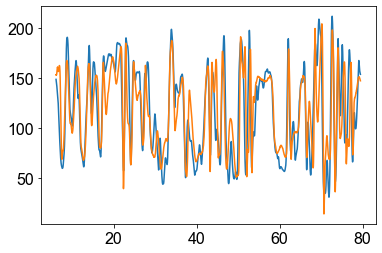

0.5944306051045514
0.1542503680517749


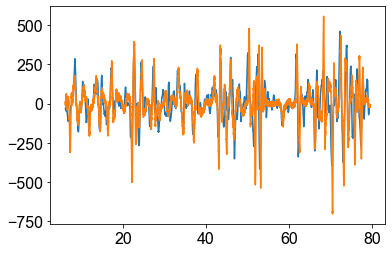

0.03038595031905056
0.13361653423225206


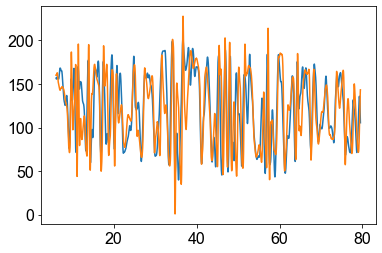

0.2971105293575145
0.2007458621308303


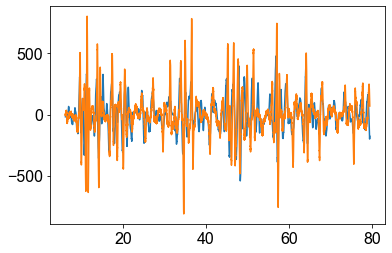

-0.5955685627087268
0.16225699893328738


In [25]:
def r2(y , yhat):
    y = np.array(y)
    yhat = np.array(yhat)
    rss = ((y-yhat)**2).sum()
    ym = y.mean()
    tss = ((y-ym)**2).sum()
    return 1 - rss/tss

def rmse(y, yhat):
    y = np.array(y)
    yhat = np.array(yhat)
    mean_err_squared = ((y - yhat)**2).mean()
    rms = np.sqrt(mean_err_squared) / (np.max(y) - np.min(y))
    return rms

for d in data:
    plt.plot(d.cr.t, d.cr.x)
    plt.plot(d.model.t, d.model.mx)
    plt.show()
    print(r2(d.cr.x, d.model.mx))
    print(rmse(d.cr.x, d.model.mx))
    
    dx = np.gradient(d.cr.x) / dt
    plt.plot(d.cr.t, dx)
    dmx = np.gradient(d.model.mx) / dt
    plt.plot(d.model.t, dmx)
    plt.show()
    print(r2(dx, dmx))
    print(rmse(dx, dmx))
    
    

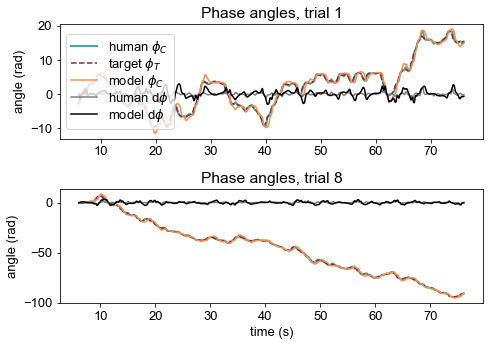

In [26]:
import matplotlib
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 13}
matplotlib.rc('font', **font)

plt.figure(figsize=[7, 5])

for idx, trial, d in zip([1,2], [1, 8], [data[0], data[7]]):
    c = d.cr
    plt.subplot(2,1,idx)
    plt.title(f"Phase angles, trial {trial}")
    
    take = np.arange(int(0/dt), int(70/dt))
    plt.plot(c.t[take], d.cph[take], label=r"human $\phi_C$", color=colors["cursor"], lw=2 )
    plt.plot(c.t[take], d.tph[take], "--", label=r"target $\phi_T$", color=colors["target"] )
    plt.plot(d.model.t[take], d.model.cph[take], label=r"model $\phi_C$", color=colors["model"])

    plt.plot(c.t[take], d.dph[take], label=r"human d$\phi$", color="gray")
    plt.plot(d.model.t[take], d.model.dph[take], label="model d$\phi$", color="black")
    if idx == 1: 
        plt.legend(prop={'size':13}, labelspacing=0, loc="center left")
    else:
        plt.xlabel("time (s)")
    plt.ylabel("angle (rad)")
    
plt.tight_layout()
#plt.savefig("..//figures//Figure6 phases.eps", format="eps", bbox_inches="tight")
plt.show()


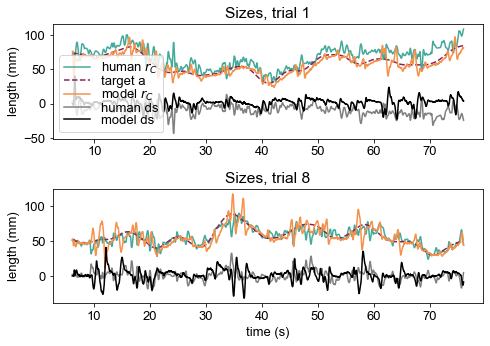

In [27]:
plt.figure(figsize=[7, 5])

for idx, trial, d in zip([1,2], [1, 8], [data[0], data[7]]):
    c = d.cr
    plt.subplot(2,1,idx)
    take = np.arange(int(0/dt), int(70/dt))
    plt.title(f"Sizes, trial {trial}")
    plt.plot(c.t[take], d.rc[take], label=r"human $r_C$", color=colors["cursor"])
    plt.plot(c.t[take], d.a[take], "--", label="target a", color=colors["target"])
    plt.plot(d.model.t[take], d.model.rc[take], label=r"model $r_C$", color=colors["model"])
    plt.ylabel("length (mm)")

    plt.plot(c.t[take], d.ds[take], label="human ds", color="gray")
    plt.plot(d.model.t[take], d.model.ds[take], label="model ds", color="black")
    
    if idx == 1:
        plt.legend(prop={'size':13}, labelspacing=0)
    else:
        plt.xlabel("time (s)")
        
plt.tight_layout()
#plt.savefig("..//figures//Figure6 sizes.eps", format="eps", bbox_inches="tight")
plt.show()

